# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# LETSA
import matplotlib.dates as mdates
from datetime import datetime
import os
import time
import ast
from functools import cache

# SA
import matplotlib.patches as mpatches

# EDD
import heapq


# Class Definitions

In [2]:
df_BOM = pd.DataFrame({
    'operation': ['F.10', 'F.20', 'D.10', 'C.10', 'A.10', 'A.20'],
    'predecessor_operations': [[], ['F.10'], [], ['D.10', 'F.20'], [], ['A.10', 'C.10']],
    'end_product': [0, 0, 0, 0, 0, 1],
    'due_date': [0, 0, 0, 0, 0, 14],
    'processing_time': [2, 3, 3, 1, 5, 2],
    'workcenter': ["WC#2", "WC#1", "WC#1", "WC#1", "WC#1", "WC#2"],
    'machine': ['M1', 'M1', 'M1', 'M1', 'M1', 'M1']
})
# display(df_BOM)
df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2"],
    'M1': [1, 1]
})
# display(df_machine)

In [3]:
# class WorkCenter:
#     def __init__(self, id, dict_machines={}):
#         self.id = str(id)
#         self.machines = dict_machines

# class Operation:
#     def __init__(self, id, processing_time, workcenter, machine, end_product, 
#                  due_date=None, successors=None, predecessors=None):
#         self.id = str(id)
#         self.successor = str(successors) if successors else None        # LETSA
#         self.predecessors = predecessors if predecessors else []        
#         self.workcenter = str(workcenter)
#         self.machine = str(machine)
#         self.processing_time = processing_time
#         self.start_time = None
#         self.end_time = None
#         self.due_date = None if due_date != due_date else due_date
#         self.scheduled = False

#         # EDD
#         self.end_product = end_product

# def load_operations_from_df(df, filename=None):
#     """
#     Loads the operation information from the df_BOM
#     Initializes an Operation object for each of the operation and stores it in the operations dictionary
#     Inputs: 
#         - df            : a dataframe consisting the BOM information  
#         - filename      : 
#     Outputs:
#         - operations    : 
#     """

#     operations = {}

#     for index, row in df.iterrows():
#         op = Operation(
#             id=str(row['operation']),
#             processing_time=row['processing_time'],
#             workcenter=row['workcenter'],
#             machine=row['machine'],
#             due_date=row['due_date'],
#             predecessors=row['predecessor_operations'],
#             end_product=row['end_product']
#         )
#         operations[op.id] = op

#     for index, row in df.iterrows():
#         current_op_id = row['operation']
#         predecessor_ops = row['predecessor_operations']
#         for predecessor in predecessor_ops:
#             operations[predecessor].successor = current_op_id
    
#     return operations

# def load_factory(df_machine):
#     factory = {}
#     for idx, row in df_machine.iterrows():
#         workcenter = row['workcenter']
#         dict_machines = {}
#         for machine in (df_machine.columns[1:]): 
#             dict_machines[machine] = [[] for _ in range(row[machine])]
#         # factory.append(WorkCenter(workcenter, dict_machines=dict_machines))
#         factory[workcenter] = WorkCenter(workcenter, dict_machines=dict_machines)
#     return factory 

# # operations = load_operations_from_df(df_BOM)
# # for operation_key in operations.keys():
# #     print(f"{operations[operation_key].id} - successor: {operations[operation_key].successor}, predecessors: {operations[operation_key].predecessors}")

# LETSA

### Classes

In [4]:
class LETSAWorkCenter:
    def __init__(self, id, dict_machines={}):
        self.id = str(id)
        self.machines = dict_machines
        # dict_machines = {'M1': [ [], [], [] ] }

class LETSAOperation:
    def __init__(self, id, processing_time, workcenter, machine, due_date=None, successors=None, predecessors=None):
        self.id = str(id)
        self.successor = str(successors) if successors else None
        self.predecessors = predecessors if predecessors else []
        self.workcenter = str(workcenter)
        self.machine = str(machine)
        self.processing_time = processing_time
        self.start_time = None
        self.end_time = None
        self.due_date = None if due_date != due_date else due_date
        self.scheduled = False

In [5]:
def LETSA_load_operations(df, filename=None):
    """
    Loads the operation information from the df_BOM
    Initializes an Operation object for each of the operation and stores it in the operations dictionary
    Inputs: 
        - df            : a dataframe consisting the BOM information  
        - filename      : 
    Outputs:
        - operations    : 
    """

    operations = {}

    for index, row in df.iterrows():
        op = LETSAOperation(
            id=str(row['operation']),
            processing_time=row['processing_time'],
            workcenter=row['workcenter'],
            machine=row['machine'],
            due_date=row['due_date'],
            predecessors=row['predecessor_operations']
        )
        operations[op.id] = op

    for index, row in df.iterrows():
        current_op_id = row['operation']
        predecessor_ops = row['predecessor_operations']
        for predecessor in predecessor_ops:
            operations[predecessor].successor = current_op_id
    
    return operations

def LETSA_load_factory(df_machine):
    factory = {}
    for idx, row in df_machine.iterrows():
        workcenter = row['workcenter']
        dict_machines = {}
        for machine in (df_machine.columns[1:]): 
            dict_machines[machine] = [[] for _ in range(row[machine])]
        # factory.append(WorkCenter(workcenter, dict_machines=dict_machines))
        factory[workcenter] = LETSAWorkCenter(workcenter, dict_machines=dict_machines)
    return factory 

# # test case for load_operations_from_df
# operations = load_operations_from_df(df_BOM)
# for operation_key in operations.keys():
#     print(f"{operations[operation_key].id} - successor: {operations[operation_key].successor}, predecessors: {operations[operation_key].predecessors}")

# factory = load_factory(df_machine)
# for key in factory.keys():
#     print(factory[key].machines)

### Functions

In [12]:
def LETSA_find_critical_path(operations, feasible_operations): 
    """
    Finds the critical path among the feasible operations.
    Inputs:
        - operations                    : dictionary {operation_id: Operation()}, a dictionary of all operations
        - feasible_operations           : list[operation_id],  a list of operation IDs that are currently feasible
    Output:
        - critical_path, critical_length
    """

    def dfs(operations, current_op_id, path, path_length, all_paths):
        """ 
        Performs recursive DFS on the operation network. 
        Inputs: 
            - operations                : dictionary {operation_id: LETSAOperation()}, dictionary of all operations 
            - current_op_id             : str, the ID of the node at which the DFS is performed
            - path                      : list, to keep track of current path
            - path_length               : float, to keep track of current path length
            - all_paths                 : list, to keep track of all possible paths 
        Output: 
            - None, perform in place
        """

        path.append(current_op_id)
        path_length += operations[current_op_id].processing_time
        
        if not operations[current_op_id].predecessors:
            all_paths.append((list(path), path_length))
        else:
            for pred in operations[current_op_id].predecessors:
                dfs(operations, pred, path, path_length, all_paths)
        
        path.pop()
        path_length -= operations[current_op_id].processing_time

    def find_all_paths(operations, feasible_operations):
        """
        Calls DFS on all the feasible operations. 
        Inputs: 
            - operations                : dictionary {operation_id: LETSAOperation()}, dictionary of all operations 
            - feasible_operations       : list [operation_id], list of all feasible operations to perform DFS on 
        """

        all_paths = []
        for op_id in feasible_operations:
            dfs(operations, op_id, [], 0, all_paths)
        return all_paths

    all_paths = find_all_paths(operations, feasible_operations)
    # print("     printing all paths")
    # for path in all_paths: 
        # print(path[0], path[1])
    critical_path, critical_length = max(all_paths, key=lambda x:x[1])

    return critical_path, critical_length

def LETSA_schedule_operations(operations, factory):
    """
    Solves the assembly scheduling problem (ASP) using the Longest End Time Scheduling Algorithm (LETSA).
    Inputs:
        - operations            : dictionary {operation_id: LETSAOperation()}, a dictionary of all operations.
        - factory               : list [WorkCenter()], a list of WorkCenter objects, containing machine information and availability
    Output:
        - scheduled_operations  : list [LETSAOperation()], a list of LETSAOperation objects with start and end time schedules.
    """

    scheduled_operations = []
    # [[Step 4]]
    i = 1
    while True:
        # print(f"Iteration {i}")
        # ================================================================================================================
        #  [[4.0]] Feasible operations = every operation that is 
        #                               (1) not scheduled, and 
        #                               (2) has all successors scheduled, OR does not have any successors
        # ================================================================================================================
        feasible_operations = [op_id for op_id, op in operations.items() if ((not op.scheduled) and (op.successor==None or operations[op.successor].scheduled))]
        # print(f"feasible operations: {feasible_operations}")
        if not feasible_operations:
            break # terminate if all operations have been scheduled

        # ===================================================================
        #  [[4.1 - 4.3]] Compute critical path only for feasible operations
        # ===================================================================
        critical_path, length = LETSA_find_critical_path(operations, feasible_operations)
        selected_operation_id = critical_path[0]
        selected_operation = operations[selected_operation_id]
        # print(f"critical path: {critical_path}, length: {length}")
        # print(f"selected operation: {selected_operation_id}")

        # =====================================================================
        # [[4.4]] Set completion/end time of the selected operation as
        #         (ii) the start time of the successor, if a successor exists
        #         (ii) the project deadline, otherwise 
        # =====================================================================
        if selected_operation.successor: 
            # if the operation has a successor 
            # then the tentative end time is the start time of the successor
            successor_id = selected_operation.successor
            tentative_completion_time = operations[successor_id].start_time
        else: 
            # else, the operation is an end product and its tentative completion time must be its own deadline
            tentative_completion_time = selected_operation.due_date

        # ============================================================================
        #   [[4.5]] For each identical machine incuded in the required work-center 
        # ============================================================================
        def check_availability(time, machine_usage): 
            """
            Returns True if the time interval does not overlap with any intervals in machine_usage, False otherwise.
                time            : (start, end)
                machine_usage   : list of tuples [(start1, end1), (start2, end2), ...]
            """
            start, end = time
            for interval in machine_usage:
                interval_start, interval_end = interval
                if not (end <= interval_start or start >= interval_end):
                    return False
            return True

        def find_latest_start_time(completion_time, processing_time, machine_usage):
            """
            completion_time : float
            processing_time : float
            machine_usage   : list of tuples [(start1, end1), (start2, end2), ...]
            
            Returns the latest possible start time such that the job can be completed
            before the completion time and does not overlap with any intervals in machine_usage.
            """
            latest_start_time = completion_time - processing_time

            # Sort the machine usage intervals by their start times
            machine_usage = sorted(machine_usage, key=lambda x: x[0])
            
            # Iterate over the machine usage intervals in reverse order
            for interval in reversed(machine_usage):
                interval_start, interval_end = interval
                
                # Check if there is a gap between the intervals where the job can fit
                if interval_end <= latest_start_time:
                    if check_availability((latest_start_time, latest_start_time + processing_time), machine_usage):
                        return latest_start_time
                latest_start_time = min(latest_start_time, interval_start - processing_time)
            
            # Check if the latest possible start time is valid
            if check_availability((latest_start_time, latest_start_time + processing_time), machine_usage):
                return latest_start_time
            
            return None

        current_workcenter_id = str(selected_operation.workcenter)
        current_workcenter = factory[current_workcenter_id]             # WorkCenter object 
        machine_type = str(selected_operation.machine)                  # machine id of required machine
        possible_machines = current_workcenter.machines[machine_type]   # [[], [], []]

        processing_time = selected_operation.processing_time
        tentative_start_time = tentative_completion_time - processing_time
        possible_start_times = []
        for machine_idx, machine_schedule in enumerate(possible_machines):
            # print(machine_idx, machine_schedule)
            # if not machine_schedule:  # If machine schedule is empty, then machine is immediately useable
            #     latest_available_start_time = tentative_completion_time - selected_operation.processing_time
            if check_availability((tentative_start_time, tentative_completion_time), machine_schedule) :
                start_time, end_time = tentative_start_time, tentative_completion_time
            else: 
                start_time = find_latest_start_time(tentative_completion_time, processing_time, machine_schedule) 
                end_time = start_time + processing_time
            possible_start_times.append((machine_idx, start_time, end_time))
            # print(start_time, end_time)

        # ============================================================================
        #   [[4.6]] Select a machine to schedule operation Jc  
        # ============================================================================
        selected_machine, finalized_start_time, finalized_end_time = max(possible_start_times, key=lambda x:x[1]) 
        current_workcenter.machines[machine_type][machine_idx].append((finalized_start_time, finalized_end_time))

        # ============================================================================
        #   [[4.7]] Delete operation Jc from the network
        #   [[4.8]] Add all eligible operations into the list of feasible operations     
        # ============================================================================
        selected_operation.start_time = start_time
        selected_operation.end_time = end_time
        selected_operation.scheduled = True
        scheduled_operations.append(selected_operation)

        i += 1 
        # print()
        
    return scheduled_operations


def LETSA_plot_gantt_chart(scheduled_operations, plot_path=None, plot_name=None):   
    fig, ax = plt.subplots(figsize=(20, 20))

    # Get unique work centers
    workcenters = list(set(str(op.workcenter) for op in scheduled_operations))
    # print(f"Unique workcenters: {workcenters}")
    # print(workcenters)

    # Generate colors for each work center
    available_colors = plt.cm.tab20.colors
    num_colors = len(available_colors)
    colors = {workcenter: available_colors[i % num_colors] for i, workcenter in enumerate(workcenters)}
    # print(f"Colors dictionary: {colors}")

    for op in scheduled_operations:
        workcenter = str(op.workcenter)
        # print(f"Processing operation {op.id} for workcenter {workcenter}")
        
        start = op.start_time
        end = op.end_time
        
        if workcenter not in colors:
            print(f"Workcenter {workcenter} not found in colors dictionary")
            continue
        
        ax.barh(workcenter, end - start, left=start, color=colors[workcenter], edgecolor='black')
        ax.text(start + (end - start) / 2, workcenter, op.id, ha='center', va='center', color='black')

    ax.set_xlabel('Time')
    ax.set_ylabel('Work Center')
    ax.set_title('Gantt Chart of LETSA schedule')
    ax.set_yticks(range(len(workcenters)))
    ax.set_yticklabels(workcenters)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    if plot_path: 
        plt.savefig(f"{plot_path}//{plot_name}.png")
        plt.close(fig)
        plt.clf()



### Test Case

[<__main__.LETSAOperation object at 0x000001C5C1A72250>, <__main__.LETSAOperation object at 0x000001C5C1A72050>, <__main__.LETSAOperation object at 0x000001C5C1A2DAD0>, <__main__.LETSAOperation object at 0x000001C5C1A71390>, <__main__.LETSAOperation object at 0x000001C5C1A72B50>, <__main__.LETSAOperation object at 0x000001C5C1A70210>]


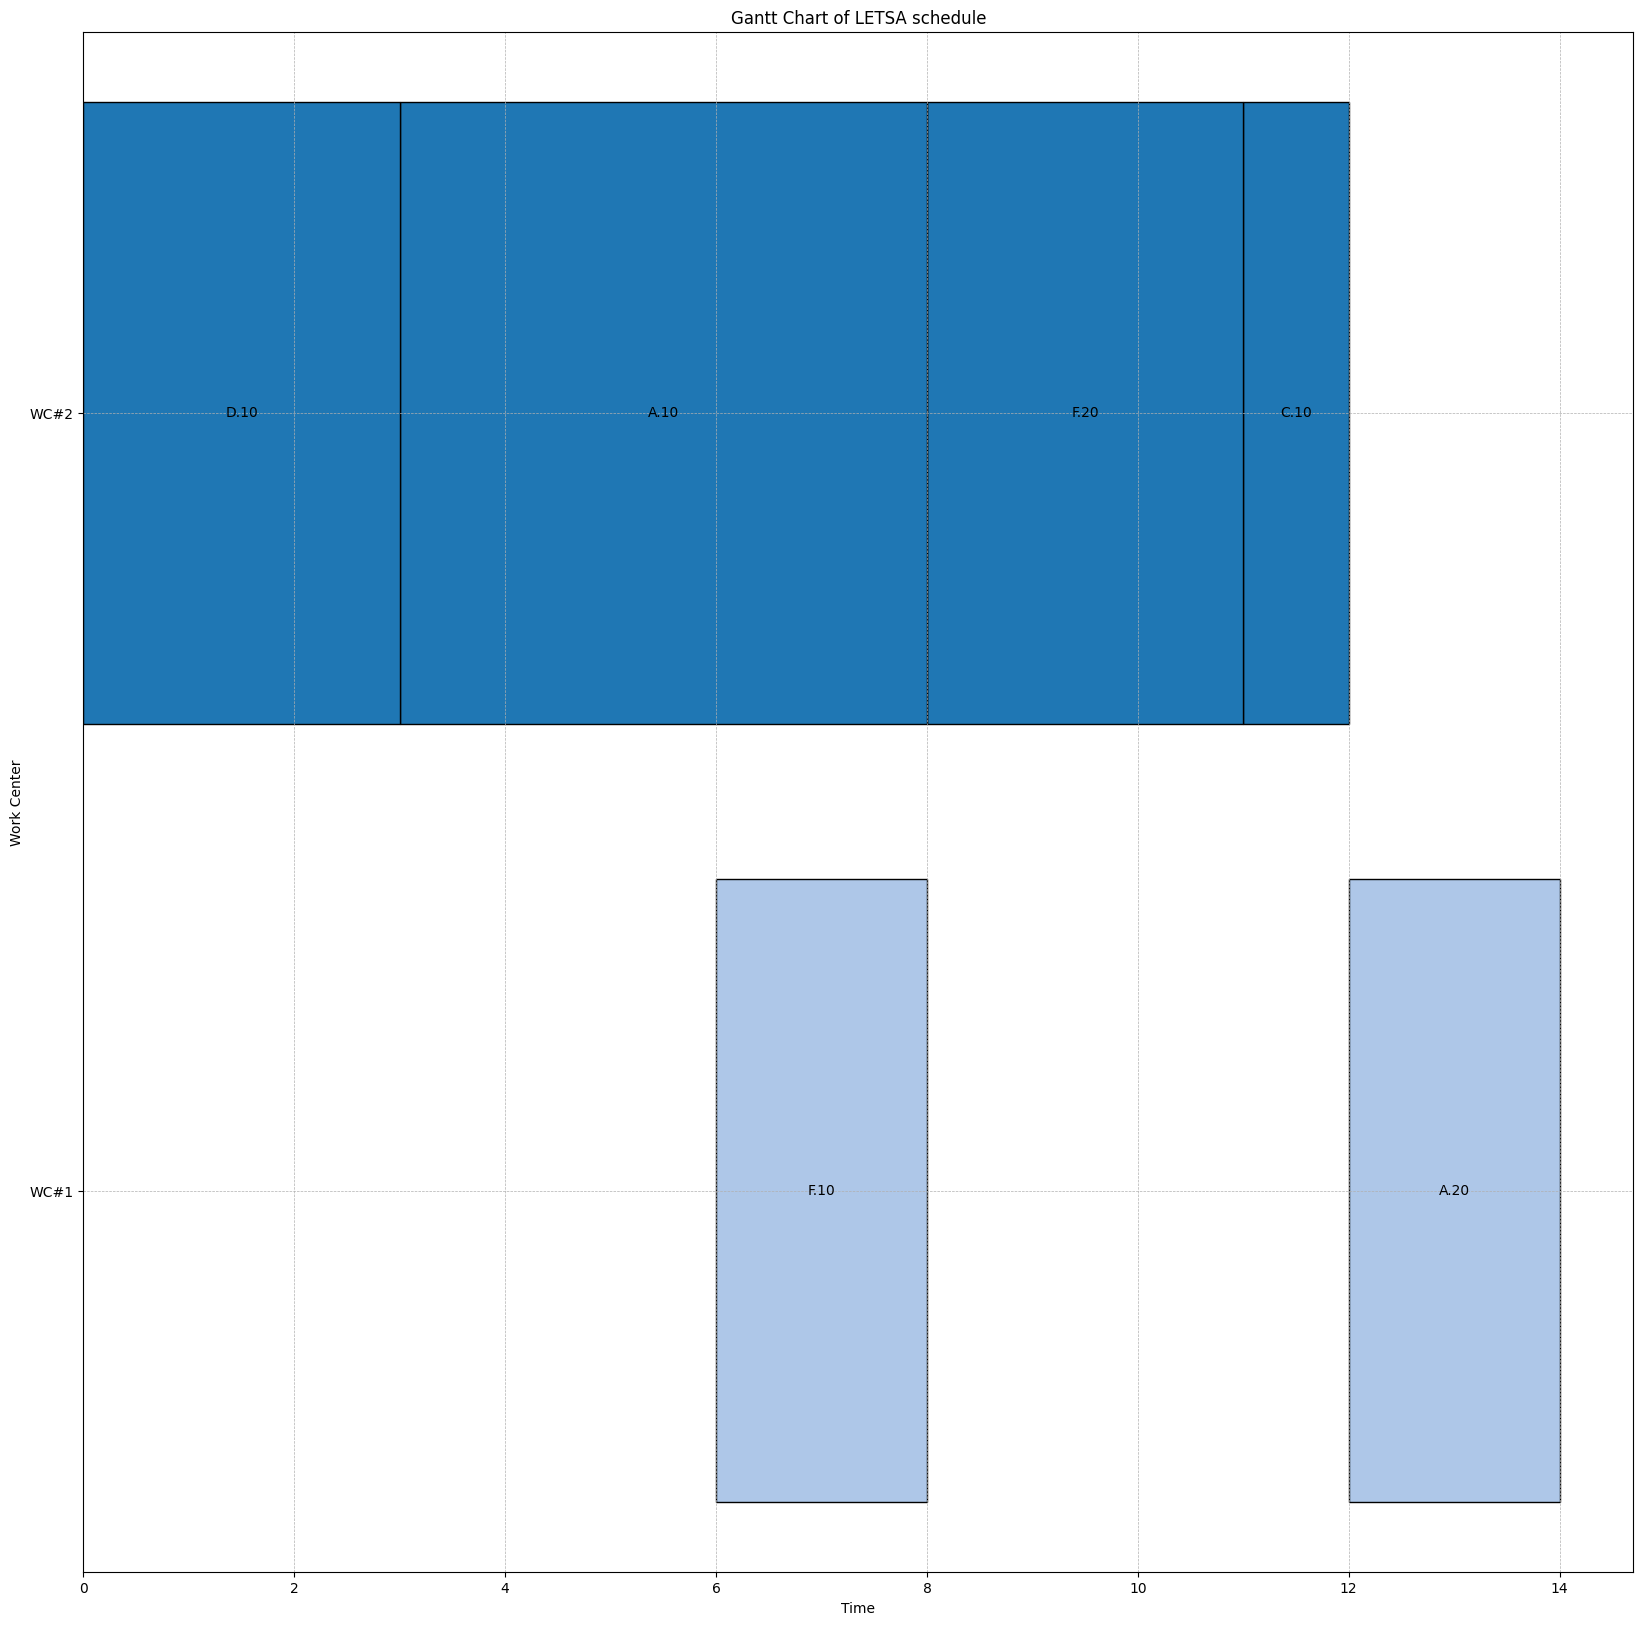

In [14]:
factory = LETSA_load_factory(df_machine)
operations = LETSA_load_operations(df_BOM)
scheduled_operations = LETSA_schedule_operations(operations, factory)
LETSA_plot_gantt_chart(scheduled_operations)
print(scheduled_operations)

,operation,predecessor_operations,end_product,due_date,processing_time,workcenter,machine
0,A,[],0,NaN,3,WC#2,M1
1,B,[],0,NaN,2,WC#1,M2
2,C,[A],0,NaN,1,WC#1,M3
3,D,[B],0,NaN,3,WC#2,M2
4,E,"[C, D]",0,NaN,1,WC#2,M4


,workcenter,M1,M2,M3,M4,M5
0,WC#1,3,2,1,1,1
1,WC#2,2,1,2,1,2
2,WC#3,3,2,1,1,3


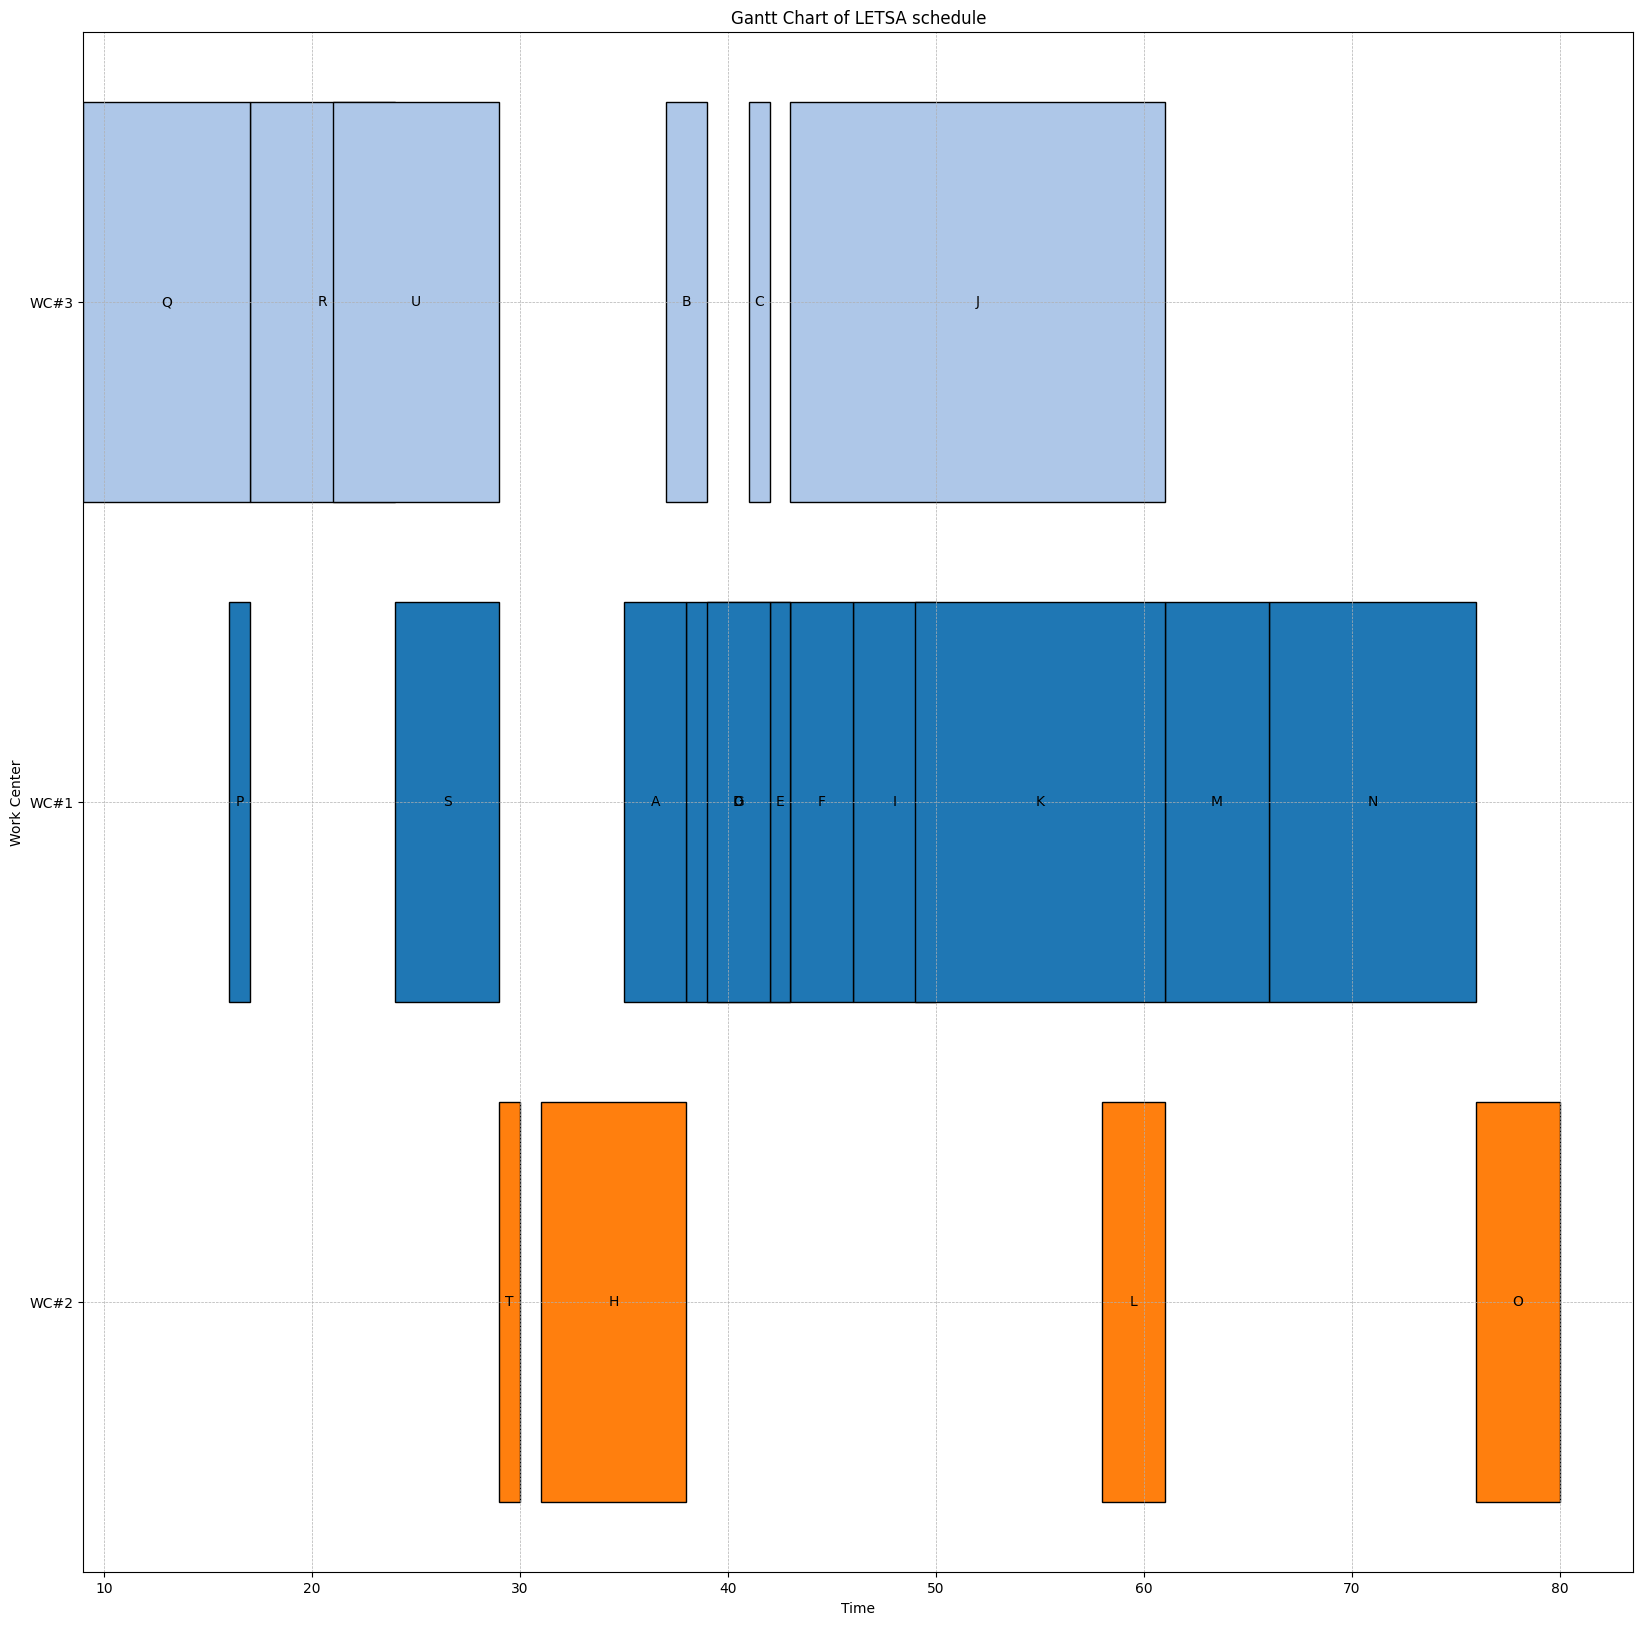

In [15]:
df_BOM = pd.DataFrame({
    'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U'],
    'predecessor_operations': [[], [], ["A"], ["B"], ["C", "D"], ["E", "G"], ["H"], [], ["F"], [], [], [], ["J", "K", "L"], ["M"], ["N"], [], [], ["P", "Q"], ["R"], ["S", "U"], []],
    'end_product': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
    'due_date': [None, None, None, None, None, None, None, None, 50.0, None, None, None, None, None, 80.0, None, None, None, None, 30.0, None],
    'processing_time': [3, 2, 1, 3, 1, 3, 5, 7, 4, 18, 12, 3, 5, 10, 4, 1, 8, 7, 5, 1, 8],
    'workcenter': ['WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#2', 'WC#3', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#3', 'WC#1'],
    'machine': ["M1", "M2", "M3", "M2", "M4", "M5", "M1", "M2", "M3", "M4", "M5", "M1", "M2", "M3", "M2", "M3", "M4", "M5", "M1", "M4", "M2"]
})
df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2", "WC#3"],
    'M1': [3, 2, 3],
    'M2': [2, 1, 2],
    'M3': [1, 2, 1],
    'M4': [1, 1, 1],
    'M5': [1, 2, 3]
})
display(df_BOM.head())
display(df_machine.head())

factory = LETSA_load_factory(df_machine)
operations = LETSA_load_operations(df_BOM)
# for operation_key in operations.keys():
#     print(f"{operations[operation_key].id} - successor: {operations[operation_key].successor}, predecessors: {operations[operation_key].predecessors}")
scheduled_operations = LETSA_schedule_operations(operations, factory)

LETSA_plot_gantt_chart(scheduled_operations)

# EDD

### Class

In [33]:
class EDDOperation:
    def __init__(self, id, predecessor_operations, end_product, due_date, processing_time, workcenter, machine):
        self.id = id
        self.predecessor_operations = predecessor_operations
        self.end_product = end_product
        self.due_date = due_date
        self.processing_time = processing_time
        self.workcenter = workcenter
        self.machine = machine
        self.start_time = None
        self.end_time = None
        self.scheduled = False

class EDDWorkCenter:
    def __init__(self, id, dict_machines={}):
        self.id = id
        self.machines = dict_machines

def EDD_load_operations(df):
    operations = {}
    for _, row in df.iterrows():
        op_id = row['operation']
        operations[op_id] = EDDOperation(
            id=op_id,
            processing_time=row['processing_time'],
            workcenter=row['workcenter'],
            machine=row['machine'],
            predecessor_operations=row['predecessor_operations'] if isinstance(row['predecessor_operations'], list) else [],
            end_product=row['end_product'],
            due_date=row['due_date']
        )
    return operations

def EDD_load_factory(df_machine):
    factory = {}
    for _, row in df_machine.iterrows():
        workcenter_id = row['workcenter']
        machines = {machine: [] for machine in df_machine.columns[1:] if row[machine] > 0}
        factory[workcenter_id] = EDDWorkCenter(id=workcenter_id, dict_machines=machines)
    return factory

df_BOM = pd.DataFrame({
    'operation': ['F.10', 'F.20', 'D.10', 'C.10', 'A.10', 'A.20'],
    'predecessor_operations': [[], ['F.10'], [], ['D.10', 'F.20'], [], ['A.10', 'C.10']],
    'end_product': [0, 0, 0, 0, 0, 1],
    'due_date': [0, 0, 0, 0, 0, 14],
    'processing_time': [2, 3, 3, 1, 5, 2],
    'workcenter': ["WC#2", "WC#1", "WC#1", "WC#1", "WC#1", "WC#2"],
    'machine': ['M1', 'M1', 'M1', 'M1', 'M1', 'M1']
})
# display(df_BOM)
df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2"],
    'M1': [1, 1]
})
# display(df_machine)

### Functions

In [30]:
def EDD_find_earliest_start_time(machine_usage, desired_start_time, processing_time):
    """
    Finds the earliest start time on the given machine that avoids overlapping with existing jobs.
    """
    # Ensure machine_usage is a list of tuples
    if not all(isinstance(interval, tuple) and len(interval) == 2 for interval in machine_usage):
        raise ValueError("Machine usage must be a list of tuples with exactly two values each.")
    
    # Flatten the list of usage intervals
    flat_usage = [interval for interval in machine_usage]
    flat_usage.sort()
    
    # print(f"Machine usage: {flat_usage}")
    # print(f"Desired start time: {desired_start_time}, Processing time: {processing_time}")

    if not flat_usage:
        return desired_start_time

    for i in range(len(flat_usage) + 1):
        if i == 0:
            interval_start = 0
            interval_end = flat_usage[i][0] if len(flat_usage) > 0 else float('inf')
        elif i == len(flat_usage):
            interval_start = flat_usage[i - 1][1]
            interval_end = float('inf')
        else:
            interval_start = flat_usage[i - 1][1]
            interval_end = flat_usage[i][0]

        # print(f"Checking interval: ({interval_start}, {interval_end})")

        if desired_start_time >= interval_start and desired_start_time + processing_time <= interval_end:
            return desired_start_time

        if interval_start + processing_time <= interval_end:
            return interval_start

    return desired_start_time


def EDD_schedule_operations(operations, factory):
    def check_availability(start_time, processing_time, machine_usage):
        """
        Returns True if the time interval does not overlap with any intervals in machine_usage, False otherwise.
        """
        end_time = start_time + processing_time
        for interval in machine_usage:
            if len(interval) != 2:
                raise ValueError("Machine usage interval does not contain exactly 2 values")
            interval_start, interval_end = interval
            if not (end_time <= interval_start or start_time >= interval_end):
                return False
        return True

    scheduled_operations = []
    Q = []
    unscheduled_dependencies = {op_id: len(op.predecessor_operations) for op_id, op in operations.items()}

    # Initialize the queue with operations that have no dependencies, sorted by due dates
    for op_id, count in unscheduled_dependencies.items():
        if count == 0:
            heapq.heappush(Q, (operations[op_id].due_date if operations[op_id].due_date is not None else float('inf'), operations[op_id].processing_time, op_id))

    while Q:
        _, _, operation_id = heapq.heappop(Q)
        operation = operations[operation_id]

        if operation.scheduled:
            continue

        # Compute start time based on dependencies
        if operation.predecessor_operations:
            max_end_time = max(
                (operations[comp_id].end_time if operations[comp_id].end_time is not None else -float('inf'))
                for comp_id in operation.predecessor_operations
            )
            operation.start_time = max_end_time
        else:
            operation.start_time = 0

        # Find the best machine and start time
        workcenter = factory[operation.workcenter]
        best_start_time = float('inf')
        selected_machine = None
        selected_machine_name = None
        
        for machine_name, machine_usages in workcenter.machines.items():
            # print(f"Machine: {machine_name}, Usages: {machine_usages}")
            
            # Ensure machine_usages is a list of tuples
            if not all(isinstance(interval, tuple) and len(interval) == 2 for interval in machine_usages):
                raise ValueError(f"Machine usages for {machine_name} in workcenter {operation.workcenter} must be a list of tuples with exactly two values each.")
                
            start_time = EDD_find_earliest_start_time(machine_usages, operation.start_time, operation.processing_time)
            if check_availability(start_time, operation.processing_time, machine_usages):
                if start_time < best_start_time:
                    best_start_time = start_time
                    selected_machine = machine_usages
                    selected_machine_name = machine_name

        if selected_machine is None:
            # No available machine found; push operation back to recheck later
            heapq.heappush(Q, (operation.due_date if operation.due_date is not None else float('inf'), operation.processing_time, operation_id))
            # print(f"Operation {operation.id} not scheduled yet, re-adding to the queue")
            continue

        # Schedule the operation
        operation.start_time = best_start_time
        operation.end_time = operation.start_time + operation.processing_time
        selected_machine.append((operation.start_time, operation.end_time))
        selected_machine.sort()

        # # Debug information
        # print(f"Operation {operation.id}: Scheduled from {operation.start_time} to {operation.end_time} on machine {selected_machine_name} in workcenter {operation.workcenter}")
        # print(f"Machine {selected_machine_name} in workcenter {operation.workcenter} usage after scheduling operation {operation.id}: {selected_machine}")

        operation.scheduled = True
        scheduled_operations.append(operation)

        # Update dependencies and add ready operations to the queue
        for op_id, op in operations.items():
            if not op.scheduled and op_id in unscheduled_dependencies:
                for comp_id in op.predecessor_operations:
                    if operations[comp_id].scheduled:
                        unscheduled_dependencies[op_id] -= 1
                if unscheduled_dependencies[op_id] == 0:
                    heapq.heappush(Q, (op.due_date if op.due_date is not None else float('inf'), op.processing_time, op_id))
                    # print(f"Operation {op_id} with no remaining dependencies added to the queue")

    # Check if all operations have been scheduled
    unscheduled_ops = [op_id for op_id, op in operations.items() if not op.scheduled]
    if unscheduled_ops:
        # print(f"Unscheduled operations remaining: {unscheduled_ops}")
        # Attempt to schedule remaining unscheduled operations
        for op_id in unscheduled_ops:
            operation = operations[op_id]
            # Compute start time based on dependencies
            if operation.predecessor_operations:
                max_end_time = max(
                    (operations[comp_id].end_time if operations[comp_id].end_time is not None else -float('inf'))
                    for comp_id in operation.predecessor_operations
                )
                operation.start_time = max_end_time
            else:
                operation.start_time = 0

            # Find the best machine and start time
            workcenter = factory[operation.workcenter]
            best_start_time = float('inf')
            selected_machine = None
            selected_machine_name = None
            
            for machine_name, machine_usages in workcenter.machines.items():
                # print(f"Machine: {machine_name}, Usages: {machine_usages}")
                
                # Ensure machine_usages is a list of tuples
                if not all(isinstance(interval, tuple) and len(interval) == 2 for interval in machine_usages):
                    raise ValueError(f"Machine usages for {machine_name} in workcenter {operation.workcenter} must be a list of tuples with exactly two values each.")
                    
                start_time = EDD_find_earliest_start_time(machine_usages, operation.start_time, operation.processing_time)
                if check_availability(start_time, operation.processing_time, machine_usages):
                    if start_time < best_start_time:
                        best_start_time = start_time
                        selected_machine = machine_usages
                        selected_machine_name = machine_name

            if selected_machine is None:
                # print(f"Operation {operation.id} could not be scheduled")
                continue

            # Schedule the operation
            operation.start_time = best_start_time
            operation.end_time = operation.start_time + operation.processing_time
            selected_machine.append((operation.start_time, operation.end_time))
            selected_machine.sort()

            # # Debug information
            # print(f"Operation {operation.id}: Scheduled from {operation.start_time} to {operation.end_time} on machine {selected_machine_name} in workcenter {operation.workcenter}")
            # print(f"Machine {selected_machine_name} in workcenter {operation.workcenter} usage after scheduling operation {operation.id}: {selected_machine}")

            operation.scheduled = True
            scheduled_operations.append(operation)

    return scheduled_operations


In [31]:
def EDD_plot_gantt_chart(scheduled_operations, plot_path=None, plot_name=None):   
    fig, ax = plt.subplots(figsize=(20, 20))

    # Get unique work centers
    workcenters = list(set(str(op.workcenter) for op in scheduled_operations))

    # Generate colors for each work center
    available_colors = plt.cm.tab20.colors
    num_colors = len(available_colors)
    colors = {workcenter: available_colors[i % num_colors] for i, workcenter in enumerate(workcenters)}

    for op in scheduled_operations:
        workcenter = str(op.workcenter)
        
        start = op.start_time
        end = op.end_time
        
        if workcenter not in colors:
            print(f"Workcenter {workcenter} not found in colors dictionary")
            continue
        
        ax.barh(workcenter, end - start, left=start, color=colors[workcenter], edgecolor='black')
        ax.text(start + (end - start) / 2, workcenter, op.id, ha='center', va='center', color='black')

    ax.set_xlabel('Time')
    ax.set_ylabel('Work Center')
    ax.set_title('Gantt Chart of EDD schedule')
    ax.set_yticks(range(len(workcenters)))
    ax.set_yticklabels(workcenters)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    if plot_path: 
        plt.savefig(f"{plot_path}//{plot_name}.png")
        plt.close(fig)
        plt.clf()

def EDD_plot_gantt_chart_by_workcenters(scheduled_operations, plot_path=None, plot_name=None):
    # Create a dictionary to store operations by work centers and machines
    workcenter_machine_operations = {}
    
    for op in scheduled_operations:
        key = (op.workcenter, op.machine)
        if key not in workcenter_machine_operations:
            workcenter_machine_operations[key] = []
        workcenter_machine_operations[key].append(op)
    
    # Create a new figure for each work center
    workcenters = list(set(op.workcenter for op in scheduled_operations))
    num_workcenters = len(workcenters)
    
    for workcenter in workcenters:
        fig, ax = plt.subplots(figsize=(20, 10))
        machines = [machine for wc, machine in workcenter_machine_operations.keys() if wc == workcenter]
        
        for i, machine in enumerate(machines):
            ops = [op for wc, mach in workcenter_machine_operations.keys() if wc == workcenter and mach == machine
                   for op in workcenter_machine_operations[(wc, mach)]]
            
            for op in ops:
                start = op.start_time
                end = op.end_time
                ax.barh(f"{workcenter} - {machine}", end - start, left=start, color='skyblue', edgecolor='black')
                ax.text(start + (end - start) / 2, f"{workcenter} - {machine}", op.id, ha='center', va='center', color='black')
        
        ax.set_xlabel('Time')
        ax.set_ylabel('Machine')
        ax.set_title(f'Gantt Chart for Work Center {workcenter}')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        if plot_path:
            plt.savefig(f"{plot_path}/{workcenter}_{plot_name}.png")
        plt.show()
        plt.close(fig)

In [32]:
operations = EDD_load_operations(df_BOM)
factory = EDD_load_factory(df_machine)
scheduled_operations = EDD_schedule_operations(operations, factory)

# Plot the Gantt charts
# EDD_plot_gantt_chart(scheduled_operations)
# EDD_plot_gantt_chart_by_workcenters(scheduled_operations)


# SA